In [1]:
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
# Load embedding helper functions
import embedding_functions as ef

# Hyperparameters

First, we specify variables for our hyperparameters so that we are able to easily change them if need be.

In [2]:
from keras.callbacks import EarlyStopping

In [3]:
dropout_rate = 0.0025
num_units = 20 
num_epoch = 300
validation = 0.1
max_len = 191
batch_size = 32 
patience = 10
callback = EarlyStopping(monitor='loss', patience=patience)
num_folds = 10

# Load and Prepare Data

We need to load our previously created word embedding matrix (see Data Preprocessing notebook), our cleaned training data and test data and prepare the data in such a way that we can use it as input/target for our model.

In [4]:
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
import ast

Embeddings:

In [5]:
# Load embeddings
emb_matrix = pickle.load(open('data/embeddings_matrix.obj', 'rb'))

Training:

In [6]:
# Load training paragraphs
train_cleaned = pd.read_csv('data/dpm_train.csv')

# Prepare input for embedding (tokenize and convert to embedding matrix indices)
train_sequences = []
for par in train_cleaned.text:
    train_sequences.append(ef.inp2array(par))

# Pad input sequences to maximum paragraph length
x_train = pad_sequences(train_sequences, max_len)

# Load train labels (lower level & higher level)
# We need to turn the labels (currently list of strings) into a list of lists
y_train_low = train_cleaned.loc[:, 'label'].to_numpy()
y_train_low = np.array([np.array(ast.literal_eval(x)) for x in y_train_low])
y_train_high = train_cleaned.loc[:, 'higher level label'].to_numpy()
y_train_high = np.array([np.array(ast.literal_eval(x)) for x in y_train_high])


Testing:

In [7]:
# Load test paragraphs
test = pd.read_csv('data/dpm_test.csv')

# Prepare input for embedding (tokenize and convert to embedding matrix indices)
test_sequences = []
for par in test.text:
    test_sequences.append(ef.inp2array(par))

# Pad input sequences to maximum paragraph length
x_test = pad_sequences(test_sequences, max_len, truncating='post') #truncating argument just for safety

# Load test labels (lower level & higher level)
# We need to turn the labels (currently list of strings) into a list of lists
y_test_low = test.loc[:, 'label'].to_numpy()
y_test_low = np.array([np.array(ast.literal_eval(x)) for x in y_test_low])
y_test_high = test.loc[:, 'higher level label'].to_numpy()
y_test_high = np.array([np.array(ast.literal_eval(x)) for x in y_test_high])


We will now create bidirectional LSTM models using the open-source software library Keras. In a first step we will implement a simpler BiLSTM model with wich we will test performance differences depending on whether we train on lower or higher level labels. Afterwards we will investigate how that lower level performance compares to a model that trained on lower level labels with 10-fold cross validation.

# Simpler BiLSTM

## Create Underlying Model

First we will build the underlying model with all its encoding layers and settings before using this base model to train on the two different label options (higher VS. lower level labels).

In [8]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense
from tensorflow.keras.models import Model

In [9]:
# Create input layer
input = Input(shape=(max_len,), dtype='int64', name='Input') # none for unspecific input length (of sequences of integers)

# Create embedding layer
embedding_layer = Embedding(emb_matrix.size(dim=0), emb_matrix.size(dim=1), embeddings_initializer=keras.initializers.Constant(emb_matrix),trainable = False, name = 'Embeddings')(input) # trainable = False to keep the embeddings fixed

# Create LSTM layers
lstm_layer = Bidirectional(LSTM(num_units, dropout=dropout_rate, recurrent_dropout=dropout_rate, return_sequences=True), name='LSTM_1')(embedding_layer) 

lstm_layer2 = Bidirectional(LSTM(num_units, dropout=dropout_rate, recurrent_dropout=dropout_rate), name='LSTM_2')(lstm_layer)

# Output/classification layer needs to be defined according to number of labels

We will check that our model looks like we want it to using Keras' summary function:

In [10]:
# Output/classification layer
output_size = 7
output = Dense(output_size, activation='sigmoid', name='Output')(lstm_layer2)

# Show a summary using a dummy model
model = Model(inputs=input, outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 191)]             0         
                                                                 
 Embeddings (Embedding)      (None, 191, 300)          2471100   
                                                                 
 LSTM_1 (Bidirectional)      (None, 191, 40)           51360     
                                                                 
 LSTM_2 (Bidirectional)      (None, 40)                9760      
                                                                 
 Output (Dense)              (None, 7)                 287       
                                                                 
Total params: 2,532,507
Trainable params: 61,407
Non-trainable params: 2,471,100
_________________________________________________________________
None


Let's represent our model more visually:

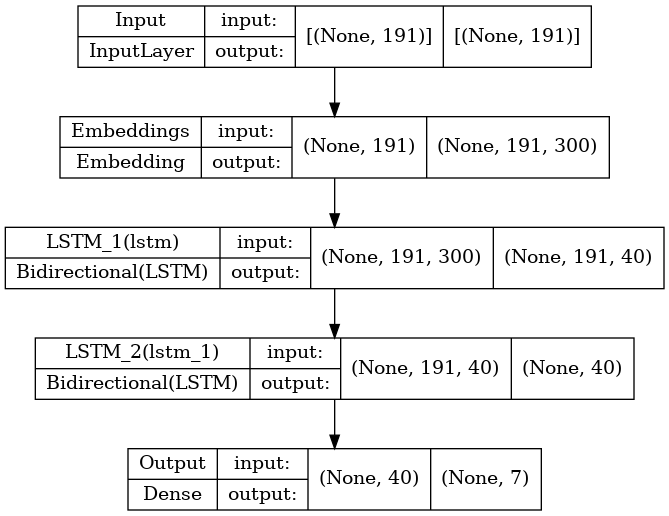

In [11]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

## Use Model on Data

### With Lower Level Labels

In [32]:
# Output/classification layer
output_size = 7 # because we have 7 lower level labels
output = Dense(output_size, activation='sigmoid', name='Output')(lstm_layer2)

# Initialise new model for training on lower level labels
model_low = Model(inputs=input, outputs=output)
model_low.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

# Fit model on train data
hist_low = model_low.fit(x_train.tolist(), y_train_low.tolist(), epochs=num_epoch, batch_size = batch_size, callbacks=[callback], verbose=0)

# Get performance score
model_low.evaluate(x_train, y_train_low)

26/26 [==============================] - 5s 130ms/step - loss: 0.0226 - accuracy: 0.6405


[0.022600101307034492, 0.6404907703399658]

Convert predictions for test data into a shape expected by our evaluation script and save for future use

In [33]:
pred_low = model_low.predict(x_test)
# Convert predicted continuous values between 0 and 1 to discrete values.
pred_low_encoded = (pred_low > 0.5).astype(np.int32) 

In [37]:
# Save lower level predictions as pickle object for future use
pklobj = open('data/pred_low.obj','wb')
pickle.dump(pred_low_encoded,pklobj)
pklobj.close()
# Save history for future use
pklobj = open('data/hist_low.obj','wb')
pickle.dump(hist_low.history,pklobj)
pklobj.close()

### With Higher Level Labels

In [38]:
# Output/classification layer
output_size = 3 # because we have 3 higher level labels
output = Dense(output_size, activation='sigmoid', name='Output')(lstm_layer2)

# Initialise new model for training on higher level labels
model_high = Model(inputs=input, outputs=output)
model_high.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit model on train data
hist_high = model_high.fit(x_train.tolist(), y_train_high.tolist(), epochs=num_epoch, batch_size = batch_size, callbacks=[callback], verbose=0) 
model_high.evaluate(x_train, y_train_high)


26/26 [==============================] - 3s 89ms/step - loss: 0.0017 - accuracy: 0.8638


[0.0017292824340984225, 0.8638036847114563]

Convert predictions for test data into a shape expected by our evaluation script and save for future use

In [39]:
pred_high = model_high.predict(x_test)
# Convert predicted continuous values between 0 and 1 to discrete values.
pred_high_encoded = (pred_high > 0.5).astype(np.int32)

In [40]:
# Save lower level predictions as pickle object for future use
pklobj = open('data/pred_high.obj','wb')
pickle.dump(pred_high_encoded,pklobj)
pklobj.close()
# Save history for future use
pklobj = open('data/hist_high.obj','wb')
pickle.dump(hist_high.history,pklobj)
pklobj.close()

## View losses and accuracy during training

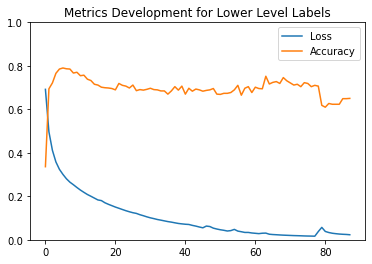

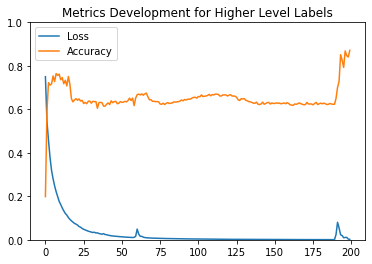

In [42]:
import matplotlib.pyplot as plt

# Load histories
hist_low = pickle.load(open('data/hist_low.obj','rb'))
hist_high = pickle.load(open('data/hist_high.obj','rb'))

plt.figure(1)
plt.plot(hist_low['loss'], label='Loss')
plt.plot(hist_low['accuracy'], label='Accuracy')
plt.ylim(0,1)
plt.legend()
plt.title('Metrics Development for Lower Level Labels')

plt.figure(2)
plt.plot(hist_high['loss'], label='Loss')
plt.plot(hist_high['accuracy'], label='Accuracy')
plt.ylim(0,1)
plt.legend()
plt.title('Metrics Development for Higher Level Labels')
plt.show()

Due to early stopping, both models trained for a different number of epochs.

## Evaluation

In order to properly evaluate the multilabel classification results we will use our extended evaluation script that will show us accuracy, precision, recall and F1 measure for each PCL category separately.

In [43]:
# Load predictions
pred_low = pickle.load(open('data/pred_low.obj', 'rb'))
pred_high = pickle.load(open('data/pred_high.obj', 'rb'))

In [44]:
import dontpatronizeme.ext_evaluation
print('Sum lower level predictions: ',pred_low.sum(axis=0))
print('Sum higher level predictions: ',pred_high.sum(axis=0))

Sum lower level predictions:  [134  35  21  33  24  68   2]
Sum higher level predictions:  [140  60  93]


We can already see that, in contrast to our Logistic Regression approach, the simple BiLSTM predicts labels for all of the given lower level categories. Additionally, our BiLSTM model also predicts higher level labels more diversely than the logistic regression model.

In [45]:
dontpatronizeme.ext_evaluation.evaluate(y_test_low, pred_low, 'll')

Unbalanced Power Relations
Accuracy: 0.8022598870056498
Precision: 0.9029850746268657
Recall: 0.8461538461538461
F1 Score: 0.8736462093862816
Confusion Matrix: (tn, fp / fn, tp)
[[ 21  13]
 [ 22 121]]
--------------------------------------------------
Shallow Solution
Accuracy: 0.7627118644067796
Precision: 0.45714285714285713
Recall: 0.41025641025641024
F1 Score: 0.4324324324324324
Confusion Matrix: (tn, fp / fn, tp)
[[119  19]
 [ 23  16]]
--------------------------------------------------
Presupposition
Accuracy: 0.7627118644067796
Precision: 0.5714285714285714
Recall: 0.26666666666666666
F1 Score: 0.36363636363636365
Confusion Matrix: (tn, fp / fn, tp)
[[123   9]
 [ 33  12]]
--------------------------------------------------
Authority Voice
Accuracy: 0.7570621468926554
Precision: 0.5454545454545454
Recall: 0.391304347826087
F1 Score: 0.4556962025316456
Confusion Matrix: (tn, fp / fn, tp)
[[116  15]
 [ 28  18]]
--------------------------------------------------
Metaphor
Accuracy: 0.7

The accuracies of the BiLSTM for lower level labels lie between 68% and 93%, which is a little bit higher than the logistic regression model but as we have noticed before, this is not very meaningful for our data. The F1 score gives a more accurate picture, in comparison to the logistic regression model, the average F1 score has pretty much doubled.

Like the logistic regression model, the BiLSTM model has a F1-score of 0.0 for the category The poorer the merrier, but at least there are two false positives, which means that, although it mislabeled two paragraphs, the model generalised something about this category and tried to apply these generalisations. 
In contrast to the logistic regression model, this category is the only one with a F1 score of 0, in every other category it lies between 32% and 87%. In the catogory Unbalanced power relations the model has the highest F1 score, Compassion the second highest. 

Generally it looks like the number of samples per category correlates with the F1 score (Pearson's r of 0.937, which is not significant given the few datapoints but still is something to note)

In [44]:
dontpatronizeme.ext_evaluation.evaluate(y_test_high, pred_high, 'hl')

The saviour
Accuracy: 0.8361581920903954
Precision: 0.8903225806451613
Recall: 0.92
F1 Score: 0.9049180327868852
Confusion Matrix: (tn, fp / fn, tp)
[[ 10  17]
 [ 12 138]]
--------------------------------------------------
The expert
Accuracy: 0.6384180790960452
Precision: 0.576271186440678
Recall: 0.4657534246575342
F1 Score: 0.5151515151515152
Confusion Matrix: (tn, fp / fn, tp)
[[79 25]
 [39 34]]
--------------------------------------------------
The poet
Accuracy: 0.6666666666666666
Precision: 0.7831325301204819
Recall: 0.6132075471698113
F1 Score: 0.6878306878306878
Confusion Matrix: (tn, fp / fn, tp)
[[53 18]
 [41 65]]
--------------------------------------------------
F1 Score Average: 0.7026334119230294


On average the model performs better on higher than lower level labels than on lower lever labels. 

The savior is the category with the highest F1 score which is somewhat unsurprising since ist contains the best performing lower level label Unbalanced power relations and the well performing category Shallow solutions.
In all categories nearly all measures (except accuracy in the categories The expert and The poet) are higher than the mean of their respective lower level labels. The greatest difference can be observed for The poet, but this is due to the fact, that the zeros of The poorer the merrier skew the average to the lower end.

# k-Fold Cross Validation

Now we will now compare our previous results to the performance of a k-fold BiLSTM with cross validation. For our k value we will comply with Pérez-Almendros et al. (2020) and choose to implement 10 folds. Furthermore, in our k-fold loop we will use the basic BiLSTM layer structure we created previously.

In [19]:
from sklearn.model_selection import KFold
import dontpatronizeme.ext_evaluation

<module 'dontpatronizeme.ext_evaluation' from '/Users/antonia/Documents/Unizeug/2021_WiSe_ANLP/final-project-anlp-21-22/src/dontpatronizeme/ext_evaluation.py'>

In [15]:
# Following Code thanks to
# [https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-keras.md]

In [25]:
output_size = 7

# Define per-fold score containers
# For metrics
acc_per_fold = []
loss_per_fold = []
f1_per_fold = []
# For predictions
pred_low_cv = dict()

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=11)

# K-fold Cross Validation model evaluation
fold_no = 1

for train, test in kfold.split(x_train, y_train_low):
    # Define the model architecture
    # Use input from simpler BiLSTM created previously

    # Output/classification layer
    output = Dense(output_size, activation='sigmoid', name='Output')(lstm_layer2)

    # Instantiate model
    model_cv = Model(inputs=input, outputs=output)

    # Compile the model
    model_cv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

    # Generate a print
    print(f'Training for fold {fold_no} ...')

    history = model_cv.fit(x_train[train], y_train_low[train], epochs=num_epoch, batch_size = batch_size, callbacks=[callback], verbose=0)
    # Generate generalization metrics
    scores = model_cv.evaluate(x_train[test], y_train_low[test], verbose=0)
    
    # Save predictions in dictionary
    pred = model_cv.predict(x_test)
    pred_low_cv[fold_no] = (pred > 0.5).astype(np.int32)

    validation_prediction = model_cv.predict(x_train[test])
    validation_prediction = (validation_prediction > 0.5).astype(np.int32)

    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    f1_per_fold.append(dontpatronizeme.ext_evaluation.evaluate(y_train_low[test], validation_prediction,'ll', verbose = False))


    # Increase fold number
    fold_no = fold_no + 1


# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}% - F1-measure: {f1_per_fold[i]*100}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> F1: {np.mean(f1_per_fold)*100}% (+- {np.std(acc_per_fold)})')
print('------------------------------------------------------------------------')

Training for fold 1 ...
Training for fold 2 ...
Training for fold 3 ...
Training for fold 4 ...
Training for fold 5 ...
Training for fold 6 ...
Training for fold 7 ...
Training for fold 8 ...
Training for fold 9 ...
Training for fold 10 ...
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.29470452666282654 - Accuracy: 63.41463327407837% - F1-measure: 75.18614871765098%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.06387069821357727 - Accuracy: 60.975611209869385% - F1-measure: 92.57656278885824%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.04323999583721161 - Accuracy: 62.19512224197388% - F1-measure: 97.64790764790764%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.09908469021320343 - Accuracy: 64.63414430618286% - F1-me

Save predictions as pickle object for future use:

In [26]:
pklobj = open('data/pred_low_cv.obj','wb')
pickle.dump(pred_low_cv,pklobj)
pklobj.close()

## View loss and accuracy during training

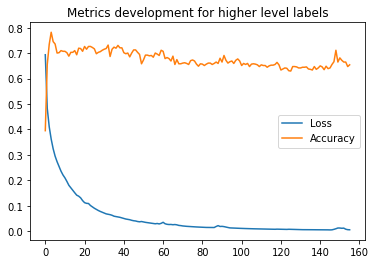

In [29]:
plt.title('Metrics development for higher level labels')
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.legend()
plt.show()

## Evaluation

Since the third fold showed the best results on the validation set, we will conduct the further evaluation with the test set on this model.

In [53]:
# Load predictions
pred_low_cv = pickle.load(open('data/pred_low_cv.obj','rb'))

import dontpatronizeme.ext_evaluation

print('Sum lower level predictions: ',pred_low_cv[3].sum(axis=0))

Sum lower level predictions:  [130  31  24  45  25  82   2]


In [52]:
dontpatronizeme.ext_evaluation.evaluate(y_test_low, pred_low_cv[3], 'll')

Unbalanced Power Relations
Accuracy: 0.7796610169491526
Precision: 0.9
Recall: 0.8181818181818182
F1 Score: 0.8571428571428572
Confusion Matrix: (tn, fp / fn, tp)
[[ 21  13]
 [ 26 117]]
--------------------------------------------------
Shallow Solution
Accuracy: 0.7740112994350282
Precision: 0.4838709677419355
Recall: 0.38461538461538464
F1 Score: 0.4285714285714286
Confusion Matrix: (tn, fp / fn, tp)
[[122  16]
 [ 24  15]]
--------------------------------------------------
Presupposition
Accuracy: 0.7231638418079096
Precision: 0.4166666666666667
Recall: 0.2222222222222222
F1 Score: 0.2898550724637681
Confusion Matrix: (tn, fp / fn, tp)
[[118  14]
 [ 35  10]]
--------------------------------------------------
Authority Voice
Accuracy: 0.7231638418079096
Precision: 0.4666666666666667
Recall: 0.45652173913043476
F1 Score: 0.46153846153846156
Confusion Matrix: (tn, fp / fn, tp)
[[107  24]
 [ 25  21]]
--------------------------------------------------
Metaphor
Accuracy: 0.751412429378531


More training effort did not yield better results compared to the simple BiLSTM. The F1-score on the test data improved in only one category, namely Authority voice, the average of the F1-score became worse (slightly). Like any other model in our experiment so far, this model also completely failed to correctly identify the category The poorer the merrier. As we have seen for the simple BiLSTM, a correlation between the number of instances of each category with the F1-score can be found (Pearson's r of 0.923).

# Summary

- Every iteration of BiLSTM model that we trained on average performed better than the logistic regression model.
- The scores of the models trained on lower level labels seem to correlate with the frequency of the respective label in the training data.
- The distinction between higher level labels works more reliably than between lower level labels.
- Training with 10-fold cross validation over all did not improve the scores of the model, the larger training effort does not pay off.